## Dữ liệu đầu vào

# Group 7 Project

### Thư viện

In [1]:
# Thư viện cơ bản
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization,
    Activation,
    GlobalAveragePooling2D,
    Conv2D,
    MaxPooling2D
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


### Dữ liệu

In [2]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

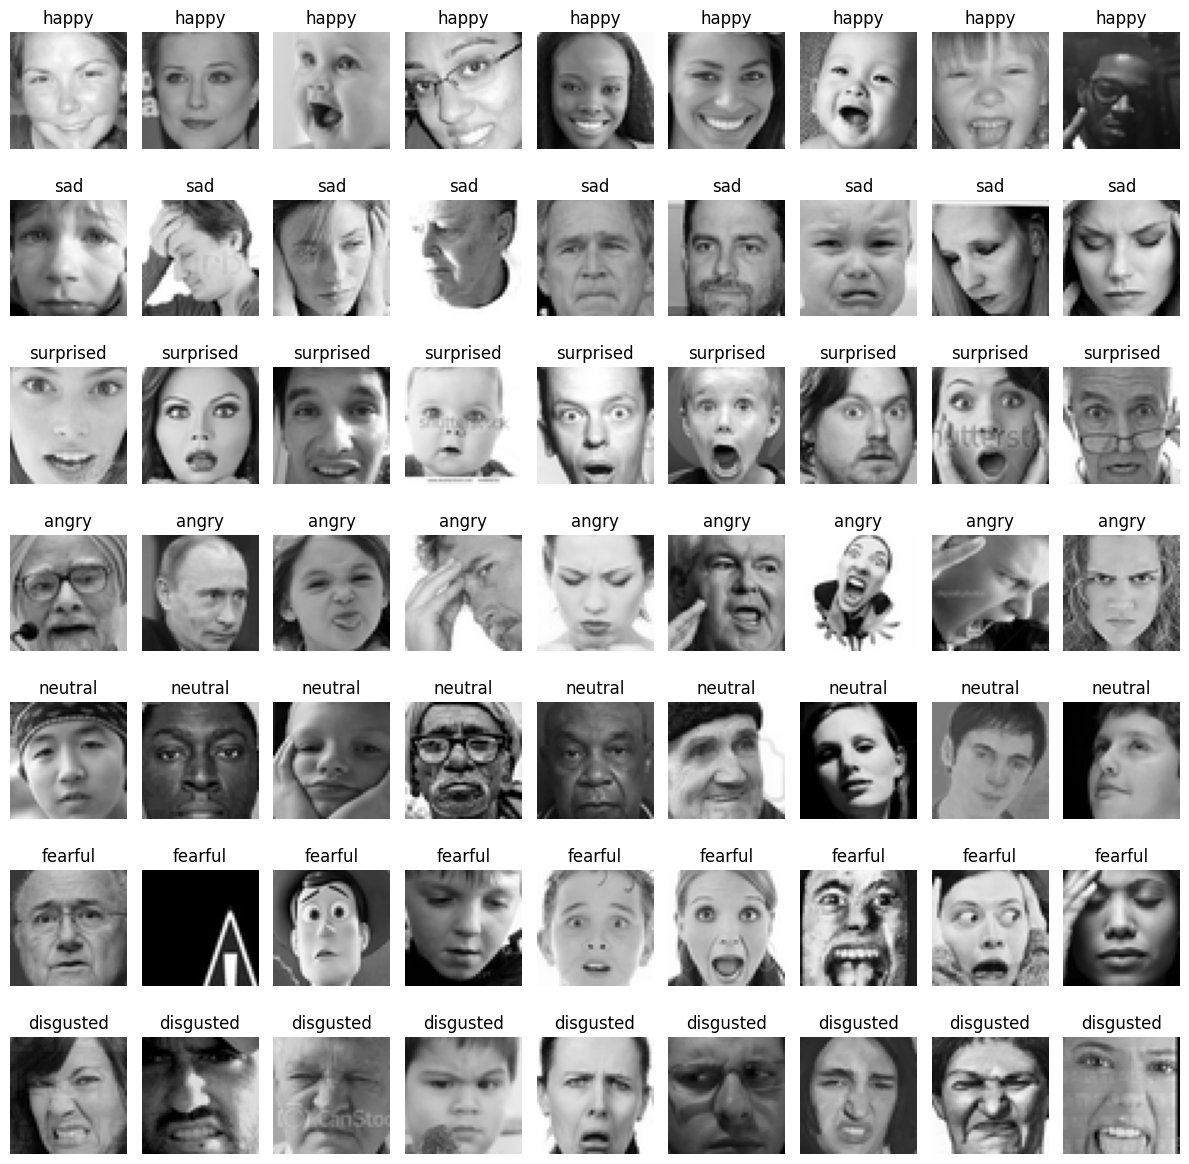

In [3]:
picture_size = 48
folder_path = "./dataset/"
expressions = ['happy', 'sad', 'surprised', 'angry', 'neutral','fearful','disgusted']  # Danh sách các cảm xúc
plt.figure(figsize=(12, 12))

for idx, expression in enumerate(expressions):
    for i in range(1, 10):
        plt.subplot(len(expressions), 9, idx * 9 + i)
        img = load_img(folder_path + "train/" + expression + "/" +
                       os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
        plt.imshow(img)
        plt.axis('off')  # Ẩn trục để hiển thị đẹp hơn
        plt.title(expression)  # Thêm label là tên cảm xúc

plt.tight_layout()  # Tự động điều chỉnh bố cục để không bị chồng lấn
plt.show()

In [4]:
# Extract image file names and labels for train_set and test_set
def extract_filenames_and_labels(data_gen):
    filepaths = data_gen.filepaths
    labels = data_gen.classes  # Numerical labels
    # Map numerical labels to class names
    class_labels = {v: k for k, v in data_gen.class_indices.items()}
    labels = [class_labels[label] for label in labels]
    return filepaths, labels

# Create DataFrame for train_set
train_files, train_labels = extract_filenames_and_labels(ImageDataGenerator().flow_from_directory(folder_path+"train",
                                              shuffle=True) )
df_train = pd.DataFrame({'Image': train_files, 'Label': train_labels})

# Create DataFrame for test_set
test_files, test_labels = extract_filenames_and_labels(ImageDataGenerator().flow_from_directory(folder_path+"test",
                                              shuffle=False))
df_test = pd.DataFrame({'Image': test_files, 'Label': test_labels})

# Display the DataFrames
print("Training Set DataFrame:")
df_train

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Training Set DataFrame:


,Image,Label
0,./dataset/train\angry\im0.png,angry
1,./dataset/train\angry\im1.png,angry
2,./dataset/train\angry\im10.png,angry
3,./dataset/train\angry\im100.png,angry
4,./dataset/train\angry\im1000.png,angry
...,...,...
28704,./dataset/train\surprised\im995.png,surprised
28705,./dataset/train\surprised\im996.png,surprised
28706,./dataset/train\surprised\im997.png,surprised
28707,./dataset/train\surprised\im998.png,surprised


In [5]:
train_dataset='./dataset/train'
test_dataset='./dataset/test'
no_of_subdirs(train_dataset,'train')

,angry,disgusted,fearful,happy,neutral,sad,surprised
train,3995,436,4097,7215,4965,4830,3171


In [6]:
print("\nTest Set DataFrame:")
df_test



Test Set DataFrame:


,Image,Label
0,./dataset/test\angry\im0.png,angry
1,./dataset/test\angry\im1.png,angry
2,./dataset/test\angry\im10.png,angry
3,./dataset/test\angry\im100.png,angry
4,./dataset/test\angry\im101.png,angry
...,...,...
7173,./dataset/test\surprised\im95.png,surprised
7174,./dataset/test\surprised\im96.png,surprised
7175,./dataset/test\surprised\im97.png,surprised
7176,./dataset/test\surprised\im98.png,surprised


In [7]:
no_of_subdirs(test_dataset,'test')

,angry,disgusted,fearful,happy,neutral,sad,surprised
test,958,111,1024,1774,1233,1247,831


## Xây dựng mô hình

### Mô hình CNN

#### Đọc và xử lý dữ liệu

In [8]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True) 


test_set = datagen_val.flow_from_directory(folder_path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


#### Xây dưng mô hình CNN

In [9]:
from keras.optimizers import Adam,SGD,RMSprop


no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))


# Compiling the model
opt = Adam(learning_rate=0.0001)  # Corrected to use learning_rate
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\MSI\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

#### Huấn luyện mô hình

In [11]:
# Importing necessary libraries
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Setting up callbacks
checkpoint = ModelCheckpoint("model-CNN.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=3,
                                         verbose=1,
                                         min_delta=0.0001)

callbacks_list =[early_stopping, checkpoint, reduce_learningrate]

epochs = 48

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # Corrected argument
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')])




In [12]:

history = model.fit(train_set,
                                    steps_per_epoch=train_set.n//train_set.batch_size,
                                    epochs=epochs,
                                    validation_data = test_set,
                                    validation_steps = test_set.n//test_set.batch_size,
                                    callbacks=callbacks_list
                                    )

Epoch 1/48


C:\Users\MSI\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8486 - loss: 1.9335 - precision: 0.3563 - recall: 0.0772
Epoch 1: val_accuracy improved from -inf to 0.86812, saving model to model-CNN.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.8486 - loss: 1.9328 - precision: 0.3569 - recall: 0.0774 - val_accuracy: 0.8681 - val_loss: 1.6745 - val_precision: 0.6140 - val_recall: 0.2070 - learning_rate: 0.0010
Epoch 2/48
  1/224 ━━━━━━━━━━━━━━━━━━━━ 3:09 851ms/step - accuracy: 0.8728 - loss: 1.3792 - precision: 0.6750 - recall: 0.2109

d:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.86812
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8728 - loss: 1.3792 - precision: 0.6750 - recall: 0.2109 - val_accuracy: 0.8571 - val_loss: 2.8900 - val_precision: 0.5000 - val_recall: 0.1000 - learning_rate: 0.0010
Epoch 3/48
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.8730 - loss: 1.4598 - precision: 0.6501 - recall: 0.2404
Epoch 3: val_accuracy improved from 0.86812 to 0.87289, saving model to model-CNN.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 207s 921ms/step - accuracy: 0.8730 - loss: 1.4596 - precision: 0.6501 - recall: 0.2405 - val_accuracy: 0.8729 - val_loss: 1.4341 - val_precision: 0.6286 - val_recall: 0.2694 - learning_rate: 0.0010
Epoch 4/48
  1/224 ━━━━━━━━━━━━━━━━━━━━ 3:10 855ms/step - accuracy: 0.8783 - loss: 1.3497 - precision: 0.7021 - recall: 0.2578
Epoch 4: val_accuracy did not improve from 0.87289
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.8783 - loss: 1.3497 - precision: 0.7021 - recall: 

## Đánh giá mô hình

In [13]:
# In các độ đo của mô hình
def print_metrics(history):
    print("Mất mát trên tập huấn luyện: ", history.history['loss'][-1])
    print("Mất mát trên tập kiểm tra: ", history.history['val_loss'][-1])
    print("Độ chính xác trên tập huấn luyện: ", history.history['accuracy'][-1])
    print("Độ chính xác trên tập kiểm tra: ", history.history['val_accuracy'][-1])
    print("Độ chính xác trung bình trên tập huấn luyện: ", history.history['precision'][-1])
    print("Độ chính xác trung bình trên tập kiểm tra: ", history.history['val_precision'][-1])
    print("Độ nhạy trên tập huấn luyện: ", history.history['recall'][-1])
    print("Độ nhạy trên tập kiểm tra: ", history.history['val_recall'][-1])

print_metrics(history)


Mất mát trên tập huấn luyện:  0.8607377409934998
Mất mát trên tập kiểm tra:  1.02347993850708
Độ chính xác trên tập huấn luyện:  0.914813220500946
Độ chính xác trên tập kiểm tra:  0.902881920337677
Độ chính xác trung bình trên tập huấn luyện:  0.7923973798751831
Độ chính xác trung bình trên tập kiểm tra:  0.7264653444290161
Độ nhạy trên tập huấn luyện:  0.5470067262649536
Độ nhạy trên tập kiểm tra:  0.5135323405265808


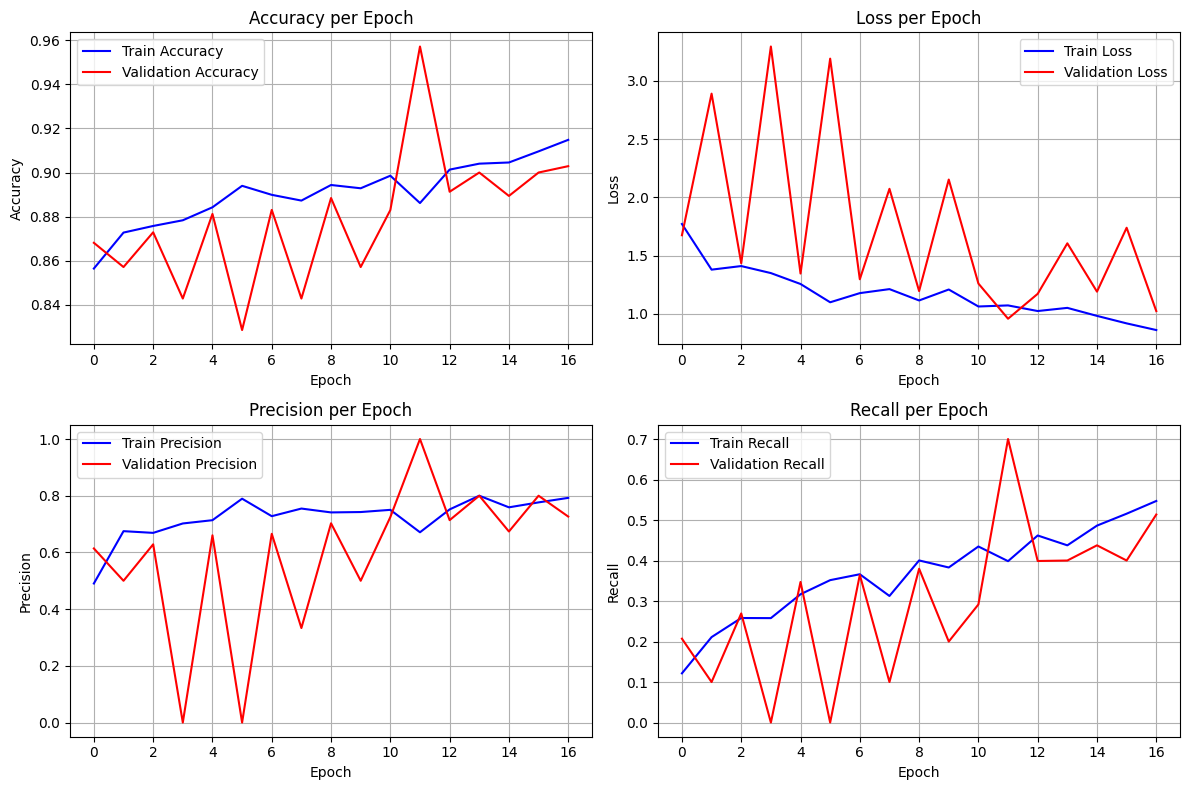

In [14]:
import matplotlib.pyplot as plt

def plot_metrics_per_epoch(history):
    # Lấy thông tin từ history
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    
    epochs = range(len(accuracy))  # Số epoch

    # Vẽ biểu đồ độ chính xác
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Vẽ biểu đồ mất mát
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Vẽ biểu đồ độ chính xác trung bình (Precision)
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precision, 'b', label='Train Precision')
    plt.plot(epochs, val_precision, 'r', label='Validation Precision')
    plt.title('Precision per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Vẽ biểu đồ độ nhạy (Recall)
    plt.subplot(2, 2, 4)
    plt.plot(epochs, recall, 'b', label='Train Recall')
    plt.plot(epochs, val_recall, 'r', label='Validation Recall')
    plt.title('Recall per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ biểu đồ
plot_metrics_per_epoch(history)


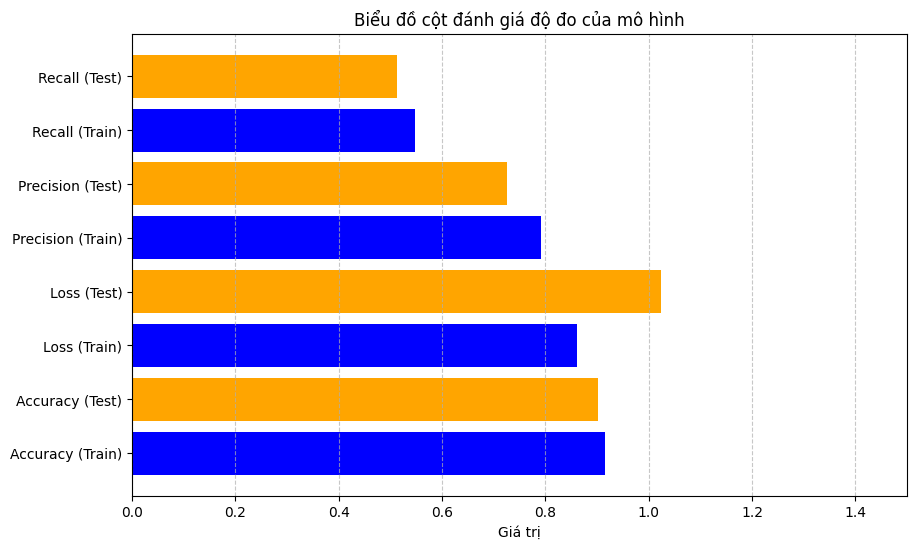

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(history):
    # Lấy các giá trị cuối cùng cho độ chính xác và mất mát
    final_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_precision = history.history['precision'][-1]
    final_val_precision = history.history['val_precision'][-1]
    final_recall = history.history['recall'][-1]
    final_val_recall = history.history['val_recall'][-1]

    # Tạo mảng cho các chỉ số
    metrics = ['Accuracy (Train)', 'Accuracy (Test)', 'Loss (Train)', 'Loss (Test)', 
               'Precision (Train)', 'Precision (Test)', 'Recall (Train)', 'Recall (Test)']
    values = [final_accuracy, final_val_accuracy, final_loss, final_val_loss,
              final_precision, final_val_precision, final_recall, final_val_recall]

    # Vẽ biểu đồ cột
    plt.figure(figsize=(10, 6))
    plt.barh(metrics, values, color=['blue', 'orange', 'blue', 'orange', 
                                       'blue', 'orange', 'blue', 'orange'])
    plt.xlabel('Giá trị')
    plt.title('Biểu đồ cột đánh giá độ đo của mô hình')
    plt.xlim(0, 1.5)  # Giới hạn trục x từ 0 đến 1.5 để dễ nhìn hơn
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Gọi hàm để vẽ biểu đồ cột
plot_bar_chart(history)
